In [1]:
# Import useful libraries

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999
pd.options.display.float_format = '{:20,.2f}'.format

# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from scipy.stats import ttest_ind
from scipy.stats import fisher_exact

From our EDA, we see that there are many variables that may have some correlation with students' grades. Therefore, we are interested to see whether we can predict a student's pass/fail status based on these variables.

## Can we predict whether a student will pass or fail both subjects according to their attributes?

In [2]:
data = pd.read_csv("Student Alcohol Consumption_clean.csv")
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,nursery,internet,MG1,MG2,MG3,PG1,PG2,PG3,_merge,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,higher,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,alc,Pedu
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,yes,no,5.00,6.00,6.00,0.00,11.00,11.00,both,mother,2.00,2.00,0.00,yes,no,no,no,yes,no,4.00,3.00,4.00,1.00,1.00,3.00,6.00,2.00,8
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,no,yes,5.00,5.00,6.00,9.00,11.00,11.00,both,father,1.00,2.00,0.00,no,yes,no,no,yes,no,5.00,3.00,3.00,1.00,1.00,3.00,4.00,2.00,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,yes,yes,7.00,8.00,10.00,12.00,13.00,12.00,both,mother,1.00,2.00,3.00,yes,no,yes,no,yes,no,4.00,3.00,2.00,2.00,3.00,3.00,10.00,5.00,2
3,GP,F,15,U,GT3,T,4,2,health,services,home,yes,yes,15.00,14.00,15.00,14.00,14.00,14.00,both,mother,1.00,3.00,0.00,no,yes,yes,yes,yes,yes,3.00,2.00,2.00,1.00,1.00,5.00,2.00,2.00,6
4,GP,F,16,U,GT3,T,3,3,other,other,home,yes,no,6.00,10.00,10.00,11.00,13.00,13.00,both,father,1.00,2.00,0.00,no,yes,yes,no,yes,no,4.00,3.00,2.00,1.00,2.00,5.00,4.00,3.00,6


First, we add a new column 'passed_both' to the dataframe by first defining 'passP' and 'passM' with the criteria for passing being 50%.

In [3]:
#define pass if the student scores >= 10 (50%) on portuguese and math
data["passP"] = data["PG3"] >= 10
data["passM"] = data["MG3"] >= 10

# assuming the math grades are in a column called 'math_grade' and the portuguese grades are in a column called 'portuguese_grade'

# define a function to check if a student passed both subjects
def passed_both(row):
    if row['MG3'] >= 10 and row['PG3'] >= 10:
        return True
    else:
        return False

# apply the function to each row of the dataframe and store the result in a new column called 'passed_both'
data['passed_both'] = data.apply(passed_both, axis=1)

We define a function to do the analysis without manually having to write each block of code.

In [14]:
def decision_tree_classifier(data, predictors, target, test_size):
    # Separate the predictors and target variable
    X = data[predictors]
    y = data[target]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Create a decision tree classifier with max depth 4
    clf = DecisionTreeClassifier()
    
    # Fit the classifier to the training data
    clf.fit(X_train, y_train)
    
    # Make predictions on the testing data
    y_pred = clf.predict(X_test)
    
    # Evaluate the performance of the classifier
    accuracy = clf.score(X_test, y_test)

    # Calculate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fail", "Pass"], yticklabels=["Fail", "Pass"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    tpTrain = cm[1][1] # True Positives : Y (1) predicted Y (1)
    fpTrain = cm[0][1] # False Positives : N (0) predicted Y (1)
    tnTrain = cm[0][0] # True Negatives : N (0) predicted N (0)
    fnTrain = cm[1][0] # False Negatives : Y (1) predicted N (0)

    print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
    print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
    print()

    print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
    print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))
    print()

    # Printing the tree
    fig, ax = plt.subplots(figsize=(40, 20))
    plot_tree(clf, filled = True, ax = ax, rounded = True, feature_names = predictors, class_names = ["Fail", "Pass"])
    
    print("Accuracy: ",accuracy)


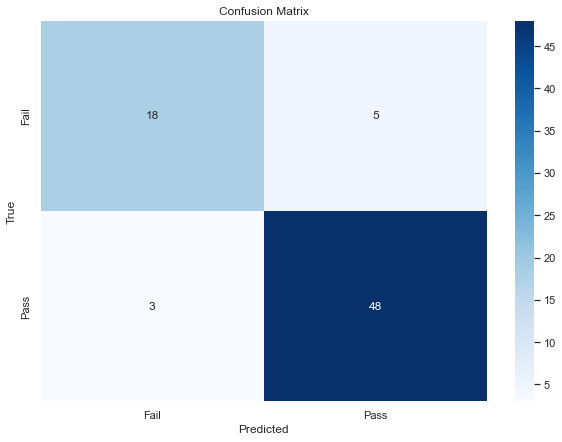

TPR Train :	 0.9411764705882353
TNR Train :	 0.782608695652174

FPR Train :	 0.21739130434782608
FNR Train :	 0.058823529411764705

Accuracy:  0.8918918918918919


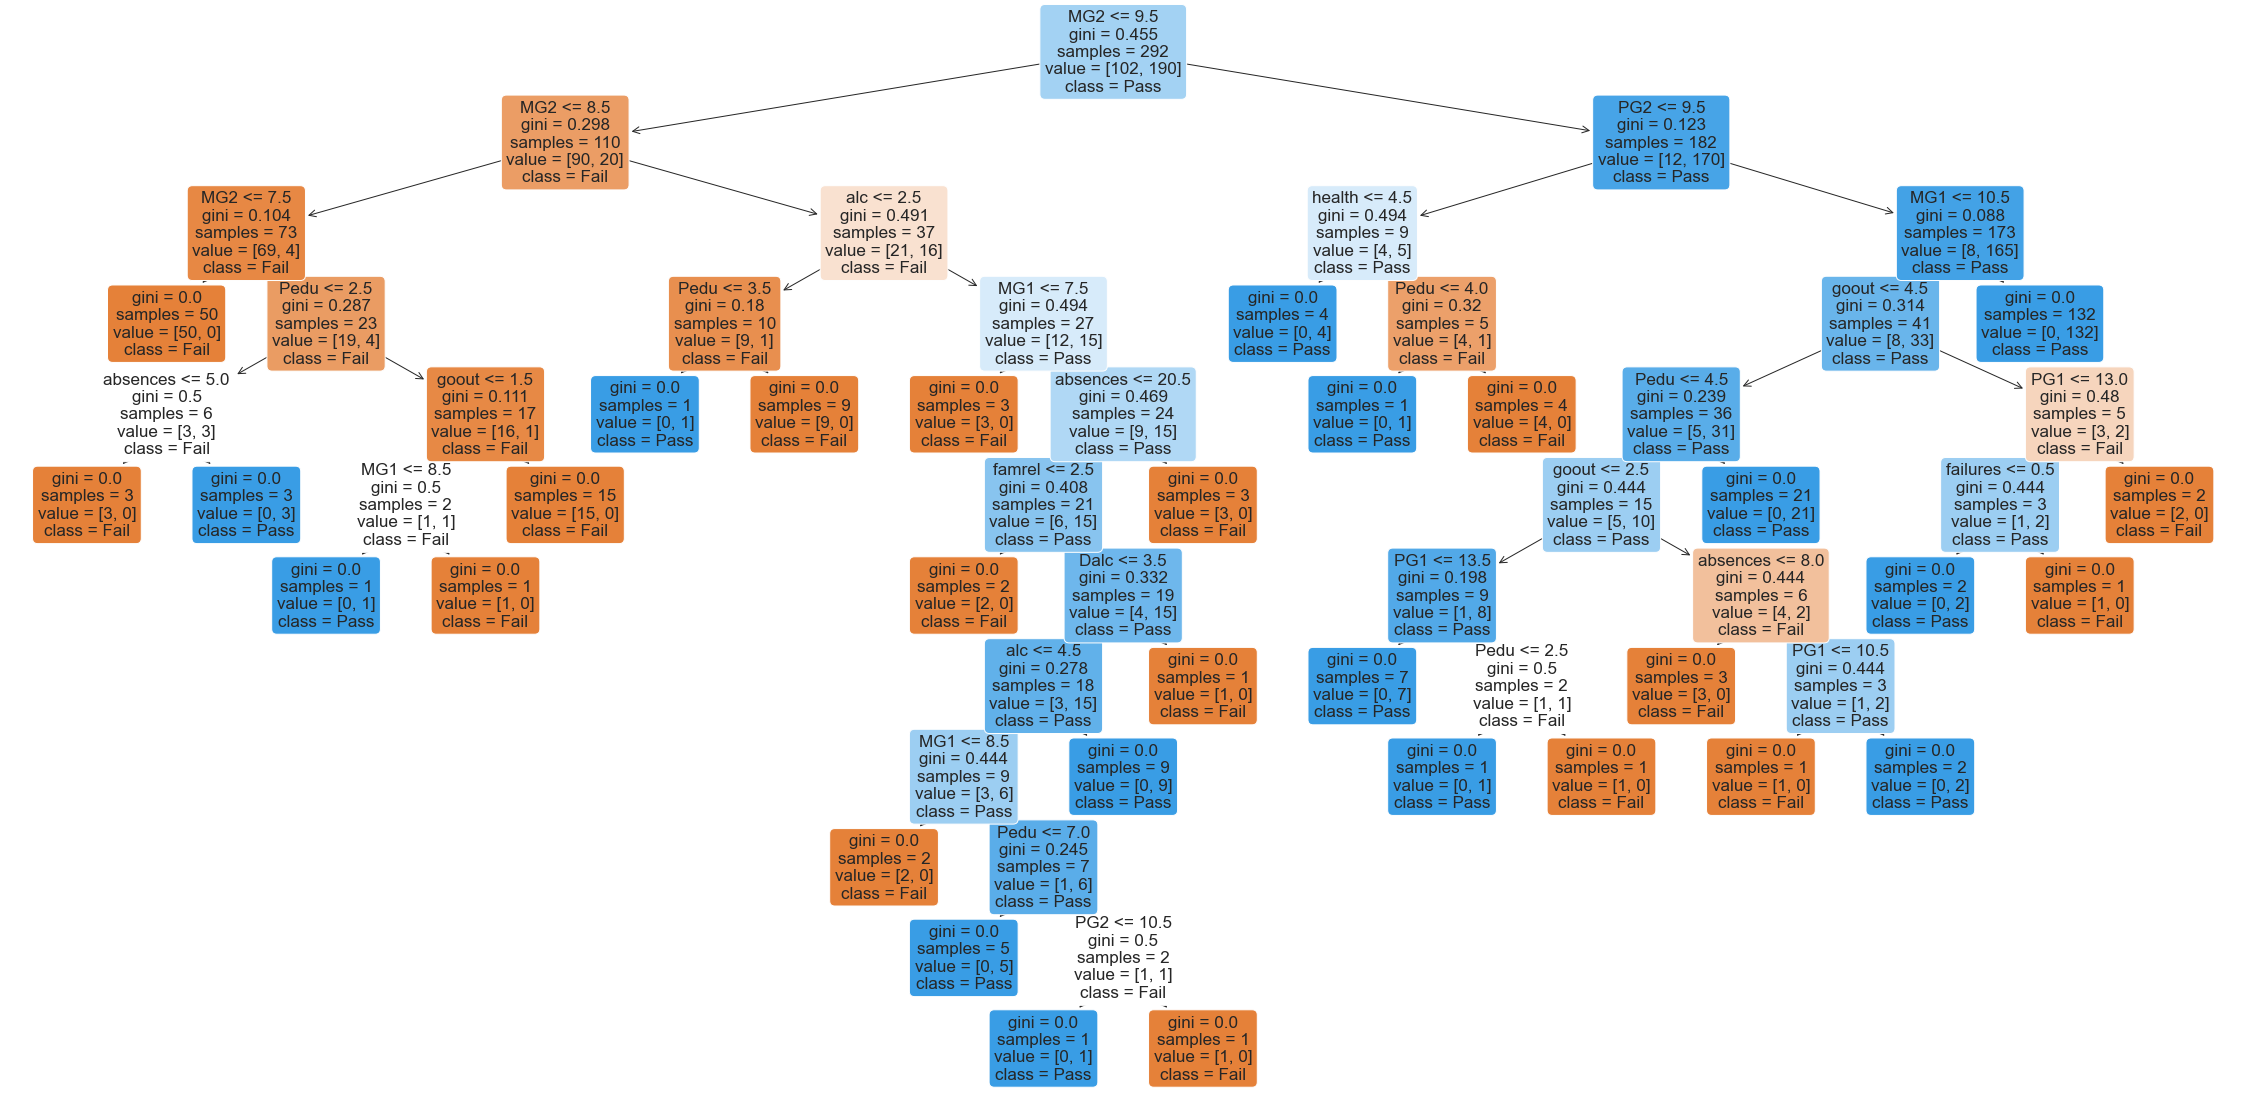

In [15]:
# Get the list of predictors
predictors = list(data.select_dtypes(include=['float64', 'int64']).columns)
for res in ['PG3', 'MG3']:
    predictors.remove(res)

# Drop rows with missing values and convert predictors to a dataframe
data_clean = data.dropna()
X = pd.DataFrame(data_clean[predictors])

# Target variable
y = data_clean['passed_both']

# Call decision_tree_classifier function
model = decision_tree_classifier(data_clean, predictors, 'passed_both', 0.2)

We also want to understand the importance of each feature/variable in this decision tree.

In [16]:
# fit decision tree classifier
model = DecisionTreeClassifier()
model.fit(X, y)

# calculate feature importances
importances = model.feature_importances_

# Print feature importances
for feature, importance in zip(predictors, importances):
    print(f"{feature} importance: {importance:.3f}")

age importance: 0.025
Medu importance: 0.002
Fedu importance: 0.017
MG1 importance: 0.047
MG2 importance: 0.650
PG1 importance: 0.021
PG2 importance: 0.030
traveltime importance: 0.000
studytime importance: 0.000
failures importance: 0.000
famrel importance: 0.015
freetime importance: 0.010
goout importance: 0.043
Dalc importance: 0.006
Walc importance: 0.010
health importance: 0.008
absences importance: 0.048
alc importance: 0.046
Pedu importance: 0.022


#### Conclusion

We see that the classification accuracy rate for the decision tree is relatively high at 0.89189 (5 significant figures). This means that our model is able to correctly predict whether students pass both subjects with a high degree of accuracy.

However, since FPR (false positive rate) is also quite high at 0.21739 (5 significant figures). This may suggest that there are other important variables not taken into account that contribute to the pass/fail status of students.

We can see that to predict students' pass/fail status, MG2 is the most important feature in making this prediction. The ranking of variables by importance is as follows:

1. MG2 importance: 0.650
2. absences importance: 0.048
3. MG1 importance: 0.047
4. alc importance: 0.046
5. goout importance: 0.043
6. PG2 importance: 0.030
7. age importance: 0.025
8. Pedu importance: 0.022
9. PG1 importance: 0.021
10. Fedu importance: 0.017
11. famrel importance: 0.015
12. freetime importance: 0.010
13. Walc importance: 0.010
14. health importance: 0.008
15. Dalc importance: 0.006
16. Medu importance: 0.002
17. traveltime importance: 0.000
18. studytime importance: 0.000
19. failures importance: 0.000

Interestingly, while traveltime, studytime and failures have higher correlation with grades (as shown in EDA) compared to other variables, they have the lowest importance in predicting students' pass/fail status. 

This may be because these variables do not have enough unique information to help the decision tree classify whether a student will pass or fail. 

Moreover, other features that rank high in importance may have non-linear relationships with grades, which is not represented in the correlation matrix.

### How can we make use of this Decision Tree Classifier?

A possible usage of this Decision Tree Classifier is for schools/teachers to support students for their final exams better. For example, students who are more likely to fail may be identified and receive more school support to better prepare them for their finals. However, schools should not wholly depend on the Decision Tree model to identify failing students as there may be false positives (students who appear to be passing but will actually fail).